In [2]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from daceypy import array, DA
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial import cKDTree

from utils.libration_sense import initial_state_parser, MU, km2du, kmS2vu, CR3BP, RK78, du2km, vu2kms

Определим функцию правых частей в задаче трех тел:

In [3]:
def cr3bp(t: float, x: np.ndarray) -> np.ndarray:
    """
    RHS for the Circular Restricted Three-Body Problem (CR3BP)
    in a rotating reference frame using numpy.

    Args:
        x (np.ndarray): State vector [x, y, z, vx, vy, vz].
        t (float): Time (not used here, but kept for compatibility with ODE solvers).

    Returns:
        np.ndarray: Derivative of the state vector [vx, vy, vz, ax, ay, az].
    """
    pos = x[:3]
    vel = x[3:]

    r1_pos = np.array([MU + pos[0] - 1, pos[1], pos[2]])
    r2_pos = np.array([MU + pos[0], pos[1], pos[2]])

    r1 = np.linalg.norm(r1_pos)
    r2 = np.linalg.norm(r2_pos)

    acc_x = pos[0] + 2 * vel[1] - (MU * r1_pos[0]) / r1**3 - ((1 - MU) * r2_pos[0]) / r2**3
    acc_y = pos[1] - 2 * vel[0] - (MU * r1_pos[1]) / r1**3 - ((1 - MU) * r2_pos[1]) / r2**3
    acc_z = - (MU * r1_pos[2]) / r1**3 - ((1 - MU) * r2_pos[2]) / r2**3

    acc = np.array([acc_x, acc_y, acc_z])
    dx = np.concatenate((vel, acc))

    return dx

Уточнить НУ для получения "более замкнутых" гало-орбит:

In [4]:
def halo_qualify(orbit_type: str, number_of_orbit: int) -> tuple[float]:
    """
    Уточняет НУ для более строгой замкнутости гало-орбит из таблицы.
    """
    x0, z0, vy0, T, _, __ = initial_state_parser(orbit_type, number_of_orbit)
    p0 = np.array([x0, vy0, T])

    def objective(p: np.ndarray) -> float:
        # x0, vy0, T = p
        initial_state =  np.array([p[0], 0., z0, 0., p[1], 0.])
        t_span = (0, p[2])
        t_eval = np.linspace(t_span[0], t_span[1], 1000)
        sol = solve_ivp(cr3bp, t_span, initial_state, t_eval=t_eval, rtol=1e-13, atol=1e-13, method='LSODA')
        last_state = sol.y.T[-1]
        return np.power(last_state - initial_state, 2).sum()
    

    res = minimize(
                    objective,
                    p0,
                    method='Nelder-Mead',
                    options={
                        'disp': False,
                        'xatol': 1e-13,
                        'fatol': 1e-13,
                        'maxiter': 10000,
                        'maxfev': 10000,
                    }
                )

    x0_res, vy0_res, T_res = res.x

    return np.array([x0_res, 0., z0, 0., vy0_res, 0.]), T_res

In [5]:
def orbit_analyze(orbit_type: str, number_of_orbit: int) -> tuple[float]:
    # Сначала получим гало орбиту как набор из 1000 точек
    x0, z0, vy0, T1, _, __ = initial_state_parser(orbit_type, number_of_orbit)
    initial_state1 = np.array([x0, 0., z0, 0., vy0, 0.])
    initial_state, T = halo_qualify(orbit_type, number_of_orbit)

    # print('Разность начальныых точек: ', initial_state - initial_state1)
    # print('Разность периодов: ', T - T1)

    t_span = (0, T)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    sol = solve_ivp(cr3bp, t_span, initial_state, t_eval=t_eval, rtol=1e-13, atol=1e-13, method='LSODA')
    halo_orbit_dots = sol.y.T
    # halo_orbit_dots[-1] = halo_orbit_dots[0]

    # Далее идем по каждой 10-ой точке этой гало-орбиты и берем ее в качестве начальной точки,
    # чтобы смотреть отклонение через виток с заданной навигационной неопределенностью
    std_pos = km2du(1)          # 1 км
    std_vel = kmS2vu(0.01e-3)   # 1 см/c
    std_devs = np.array([std_pos] * 3 + [std_vel] * 3)


    # deltax_array = np.random.normal(0, std_devs, (10000, 6))
    # limits = np.array([3 * std_pos] * 3 + [3 * std_vel] * 3)
    # deltax_array = np.clip(deltax_array, -limits, limits)  # это все наши отклонения от точек гало-орбиты

    rmax_from_halo_orbit = []
    vmax_from_halo_orbit = []

    step = 50
    total_points = 1000

    # Создаем список индексов с шагом 50
    indices = list(range(0, total_points, step))  # [0, 50, 100, ..., 950]

    # Принудительно добавляем последнюю точку (индекс 999)
    if indices[-1] != total_points - 1:
        indices.append(total_points - 1)  # Добавляем 999, если его нет

    # print(indices)
    # print('0: ', halo_orbit_dots[0])
    # print('999: ', halo_orbit_dots[999])

    # Итерируемся по выбранным точкам
    for halo_orbit_dot in tqdm(halo_orbit_dots[indices], desc="Обработка точек гало-орбиты"):
        # Нужно однократно проинтегрироваться от текущей точки в DACE, чтобы получить формулу Тейлора
        DA.init(3, 6)
        initial_state_dace = array.identity(6)
        initial_state_dace[0] += halo_orbit_dot[0]
        initial_state_dace[1] += halo_orbit_dot[1]
        initial_state_dace[2] += halo_orbit_dot[2]
        initial_state_dace[3] += halo_orbit_dot[3]
        initial_state_dace[4] += halo_orbit_dot[4]
        initial_state_dace[5] += halo_orbit_dot[5]
        with DA.cache_manager():
            xf = RK78(initial_state_dace, 0.0, T, CR3BP)
        

        # Отклонения от гало-орбиты
        np.random.seed(42)
        deltax_array = np.random.normal(0, std_devs, (10000, 6))
        limits = np.array([3 * std_pos] * 3 + [3 * std_vel] * 3)
        deltax_array = np.clip(deltax_array, -limits, limits)

        # Фазовые векторы, полученные формулой Телора для возмущенных НУ после периода
        phase_vectors_pertubed = np.array([xf.eval(delta) for delta in deltax_array])

        # Находим расстояния от полученных выше точек дол гало-орбиты
        tree = cKDTree(halo_orbit_dots)
        phase_space_distances, nearest_indices = tree.query(phase_vectors_pertubed)
        pos_dists = np.linalg.norm(phase_vectors_pertubed[:, :3] - halo_orbit_dots[nearest_indices, :3], axis=1)
        vel_dists = np.linalg.norm(phase_vectors_pertubed[:, 3:] - halo_orbit_dots[nearest_indices, 3:], axis=1)

        # Нас интересует медиана расстояний выше (по координатам и скоростям), их добавляем в список
        # как нужное значение для текущей точки гало-орбиты
        rmax_from_halo_orbit.append(np.median(pos_dists))
        vmax_from_halo_orbit.append(np.median(vel_dists))

    # print('Разность: ', halo_orbit_dots[999] - halo_orbit_dots[0])
    return du2km(max(rmax_from_halo_orbit)), vu2kms(max(vmax_from_halo_orbit)), du2km(np.array(rmax_from_halo_orbit)), 1000*vu2kms(np.array(vmax_from_halo_orbit))


def plot(array1, array2):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

    # Первый график
    x1 = np.arange(len(array1)) * 50
    axes[0].plot(x1, array1, marker='o', linestyle='-', markersize=6, linewidth=2)
    axes[0].fill_between(x1, array1, color='skyblue', alpha=0.3)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Номер точки на гало-орбите [-]')
    axes[0].set_ylabel(r'$\Delta r_{median}$ [км]')

    # Второй график
    x2 = np.arange(len(array1)) * 50
    axes[1].plot(x2, array2, marker='o', linestyle='-', markersize=6, linewidth=2)
    axes[1].fill_between(x2, array2, color='lightcoral', alpha=0.3)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Номер точки на гало-орбите [-]')
    axes[1].set_ylabel(r'$\Delta v_{median}$ [м/с]')

    plt.tight_layout()
    plt.show()

In [6]:
max_dist_dev, max_vel_dev, rmax_list, vmax_list = orbit_analyze('L1', 110)

Обработка точек гало-орбиты:   0%|          | 0/21 [00:00<?, ?it/s]

Максимальное медианное отклонение за 1 период (расстояния):  477.08578854076416  [км]
Максимальное медианное отклонение за 1 период (скорости):  4.307432703125301  [м/с]


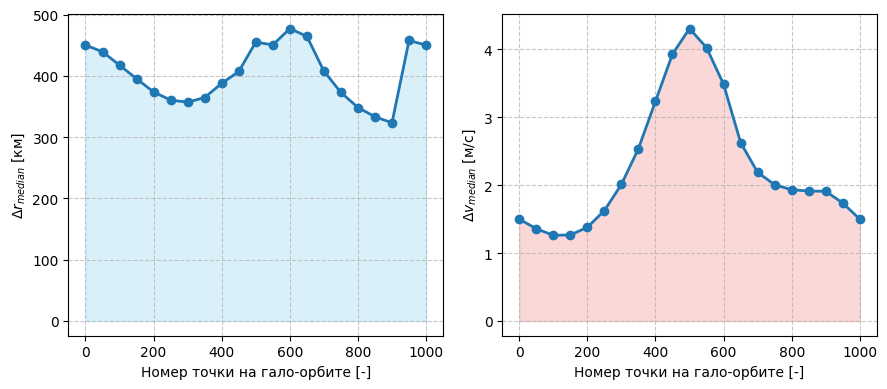

In [7]:
print("Максимальное медианное отклонение за 1 период (расстояния): ", max_dist_dev, " [км]")
print("Максимальное медианное отклонение за 1 период (скорости): ", 1000 * max_vel_dev, " [м/с]")
plot(rmax_list, vmax_list)

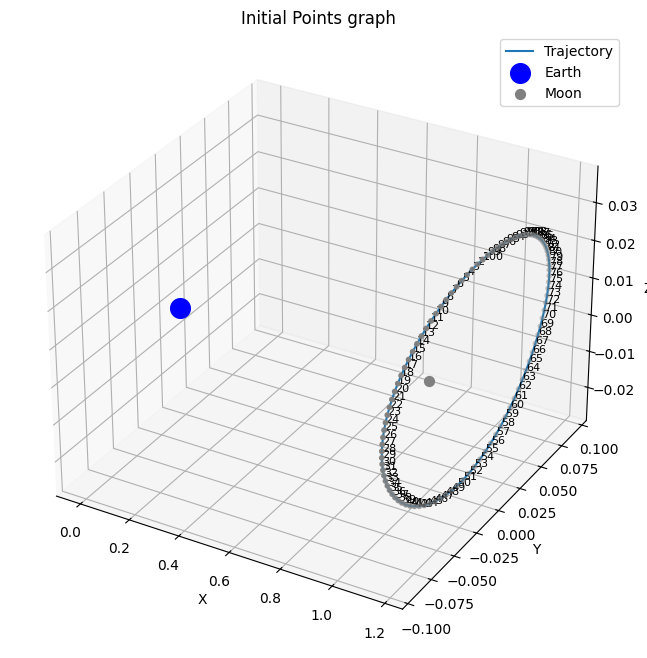

In [8]:
%matplotlib inline

x0, z0, vy0, T, _, __ = initial_state_parser("L2", 16)
initial_state = np.array([x0, 0., z0, 0., vy0, 0.])

t_span = (0, T)
t_eval = np.linspace(t_span[0], t_span[1], 100)
sol = solve_ivp(cr3bp, t_span, initial_state, t_eval=t_eval, rtol=1e-9, atol=1e-12)
halo_orbit_dots = sol.y.T

x = halo_orbit_dots[:, 0]
y = halo_orbit_dots[:, 1]
z = halo_orbit_dots[:, 2]

earth_pos = np.array([-MU, 0, 0])
moon_pos = np.array([1 - MU, 0, 0])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Trajectory', lw=1.5)
ax.scatter(x, y, z, color='gray', s=10)

for i in range(len(x)):
    ax.text(x[i], y[i], z[i], str(i+1), fontsize=8)

ax.scatter(earth_pos[0], earth_pos[1], earth_pos[2], color='blue', s=200, label='Earth')
ax.scatter(moon_pos[0], moon_pos[1], moon_pos[2], color='gray', s=50, label='Moon')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title('Initial Points graph')

plt.show()